# MNIST Digit Recognizer - Multilayer Perceptron (MLP) Classifier

**Authors: Clement, Calvin, Tilova**

---

Welcome to the second notebook by **Tequila Chicas**! We will be classifying images of hand written numbers to their corresponding digits. This project follows the guidelines and uses the data set provide from the Kaggle Competition [here](https://www.kaggle.com/competitions/digit-recognizer/overview). 

## Introduction  

In this notebook we will attempt to model the dataset using a Multilayer Perceptron (MLP). As we saw in our baseline model using Logistic Regression, we already had an accuracy score of 91%. We will try to improve this result by utilizing the complexity of a MLP and see how well we can predict the digits of the MNIST Dataset.

<a id = 'toc'></a>
    
## Table of Contents
---
1. [Simple Neural Network](#simple)
2. [Training Neural Network](#training)
3. [Simple NN Class](#simplenn)
4. [Accuracy Scores](#acc)

**Importing Libraries**

In [3]:
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train_Test_Split
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import accuracy_score

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Progress bar from tqdm
from tqdm.notebook import trange
from tqdm.notebook import tnrange

# ignores the filter warnings
import warnings
warnings.filterwarnings('ignore')

<a id = 'simple'></a>

### 1. Multilayer Perceptron
---
Loading the test and train set CSVs files.

In [5]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

We need to set our independent (X) and dependent (y) variables as `numpy arrays` from the dataset.

In [6]:
X = df_train.iloc[:, 1:].to_numpy()
y = df_train.iloc[:, 0].to_numpy()

# sanity check
print(X.shape, y.shape)

(42000, 784) (42000,)


We will perform a **train_test_split()** to split our dataset into train and validation sets.
- Validation size of 25% of the data.
- Stratify=y to make sure distribution of the classes remain the same in both training and validation set.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y)
X_train.shape, y_train.shape

((31500, 784), (31500,))

We can start by implementing a simple `linear` network.
- Since it's linear, we would obtain better results when scaling the data.

In [8]:
# instantiate standard scaler
ss = StandardScaler()

# fit and transform training
X_train = ss.fit_transform(X_train)

# ONLY transform X_val
X_test = ss.transform(X_val)

Now we need to convert the 1-D `arrays` into pytorch `tensors`
- Using type float32 to cut down memory usage
- Using torch.long for classification labels.

In [9]:
# Independent Variables
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

# Dependent Variable
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Printing shape of independent and dependent variables for sanity check
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([31500, 784]) torch.Size([31500]) torch.Size([10500, 784]) torch.Size([10500])


Let's create a sequence of neural network layers. Inside this structure, we have:

- Three layers of `nn.Linear()`
- `nn.ReLU()` between each pair of linear layers. 

In [10]:
# MLP layers
simple_neural_net = nn.Sequential(
    #providing the layers as arguments
    nn.Linear(784, 200), 
    nn.ReLU(),
    nn.Linear(200, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
    )
simple_neural_net

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=10, bias=True)
)

<a id='training'></a>

### 2. Training neural networks
Let's train the neural network on a single sample from the training dataset. 
Here are some steps to achieve this.

1. Forward Pass:
   - Pass the input tensor through the neural network to get the output values. Check if there are any gradients stored. 
3. Loss Calculation:
   - Calculate the loss by comparing the predicted output values with the actual target values using a loss function.
5. Backward Pass (Backpropagation):
   - Backward pass the loss through the network to calculate the gradient, with respect to the network parameters.
6. Weight Update:
   - Update the network weights to minimize the loss function. Once we have our weight adjustments we update the weights using `optimizer.step()`.
7. Validation:
   - Evaluate the network performance to prevent overfitting.

In [ ]:
# Creating a single row
single_row = X_train[[0], :]
single_target = y_train[[0]]

# Instantiate Optimizer
optimizer = torch.optim.SGD(simple_neural_net.parameters(), lr=0.01)

#### Forward pass ####
output_values = simple_neural_net(single_row)

# Cross Entropy Loss
cross_entropy_loss = nn.CrossEntropyLoss()
loss = cross_entropy_loss(output_values, single_target)

#### Backward pass ####
loss.backward()

# Update Weights
optimizer.step()

# New Outputs
new_output = simple_neural_net(single_row)
new_loss = cross_entropy_loss(new_output, single_target)

# Comparing old and new loss
print(f"Old loss: {loss}\nNew loss: {new_loss}")

<a id='simplenn'></a>

### 3. MLP Class

This simple PyTorch's nn.Module class computes the following:

- Constructor Method (__init__): This method initializes the neural network architecture and components. Inside the constructor, there are two options for defining the network architecture, but only one is currently active.
    - Option 1 (commented out): A basic architecture with two linear layers `nn.Linear` and ReLU activation function `nn.ReLU`. The input size is 784 (typical for flattened images of 28x28 pixels), and the output size is 10 (for classification tasks with 10 classes).
    - Option 2 (active): This is done using `nn.Sequential`, which allows stacking layers sequentially. This architecture consists of three linear layers with ReLU activation between them and dropout layers `nn.Dropout` to prevent overfitting.

- Forward Method: This method defines the forward pass of the neural network. It specifies how input data flows through the network layers to generate predictions. In this case, the forward pass simply passes the input x through the defined neural network `self.neural_net` and returns the output.

- Predict Method: This method makes predictions using the trained model. It takes input data x, passes it through the forward method to get predictions, and then converts the predictions into hard class labels by selecting the class with the highest probability using `torch.argmax`.

In [141]:
#source from BrainStation 
class SimpleNN(nn.Module):
    """Basic multi-layer architecture."""

    def __init__(self):
        """Define the main components of the network"""
        super(SimpleNN, self).__init__()
        
#         self.layer_1 = nn.Linear(784, 100) # transition from input into hidden layer
#         self.activation_1 = nn.ReLU()   # Activation function
#         self.layer_2 = nn.Linear(100, 10)  # transition from hidden layer into output

        self.neural_net = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, 10)
            )
    
    def forward(self, x):
        """Perform forward pass."""

        # pass through the layers
#         hidden_1 = self.activation_1(self.layer_1(x))
#         output = self.layer_2(hidden_1)
        
        output = self.neural_net(x)
        
        return output

    def predict(self, x):
        '''
        The class based interface allows you
        add your own functionality, like a familiar
        .predict method we all know and love
        '''

        # Predict class probabilities
        predictions = self.forward(x)

        # Find highest class prediction, notice we don't need to convert to
        # probabilities to do hard predictions, we can simply choose the
        # highest values
        hard_class_predictions = torch.argmax(predictions, dim=1)

        return hard_class_predictions

Now we can set up data loaders for training and validation datasets. We do this by setting up batch processing, shuffling the training set to prevent model overfitting, but not the validation set. 

In [142]:
####### Setting batch size #######
batch_size = 128

# Shuffle training set
training_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Don't shuffle validation set
validation_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

In [148]:
####### Parameters #######

#The learning rate determines the size of the step taken in the direction opposite to the gradient during optimization.
lr = 0.0001
# momentum = 0.9

# Instantiate the model, the loss criterion, and the optimizer
NN_model = SimpleNN()

#measures the difference between two probability distributions (the predicted probabilities and the actual distribution) 
cross_entropy_loss = nn.CrossEntropyLoss() # this includes the softmax

#Adam optimizer
optimizer = torch.optim.Adam(NN_model.parameters(), lr=lr)

In [149]:
### COMMON PYTORCH RECIPE FOR TRAINING A NETWORK ###

epoch_number = 0

total_train_loss = []
total_val_loss = []

# Now run for 25 epochs
for epoch in trange(25, desc="Total epochs: "):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    ##### Training #####
    running_loss = 0
    last_loss = 0
    
    NN_model.train(True)
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = NN_model(inputs)

        # Compute the loss and its gradients
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report (reporting only after every 1000 batches, but batch size is set manually)
        running_loss += loss.item()
#         if i % 1000 == 999:
#             last_loss = running_loss / 1000 # loss per batch
#             running_loss = 0
        #running_loss = 0
    total_train_loss.append(running_loss)
    
    ##### Validation #####
    running_vloss = 0.0
    
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    NN_model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = NN_model(vinputs)
            vloss = cross_entropy_loss(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    total_val_loss.append(avg_vloss)
    
    epoch_number += 1
    
    print('LOSS train {} valid {}'.format(running_loss, avg_vloss))
    
#     # Clear gradients (pytorch accumulates gradients by default)
#     optimizer.zero_grad()

#     # Calculate outputs
#     output_train_values = NN_model(X_train)
#     output_val_values = NN_model(X_val)

#     # Calculate train loss
#     train_loss = cross_entropy_loss(output_train_values, y_train)
#     total_train_loss.append(train_loss.detach().numpy())
    
#     # Calculate validation loss
#     val_loss = cross_entropy_loss(output_val_values, y_val)
#     total_val_loss.append(val_loss.detach().numpy())
    
#     # Backpropagation & weight adjustment
#     train_loss.backward()
#     optimizer.step()

print(f"Optimization ended successfully")

Total epochs:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH 1:
LOSS train 291.43896785378456 valid 53.67276382446289
EPOCH 2:
LOSS train 92.54970121383667 valid 43.48079299926758
EPOCH 3:
LOSS train 68.57403815537691 valid 41.411441802978516
EPOCH 4:
LOSS train 57.68309084326029 valid 32.640869140625
EPOCH 5:
LOSS train 49.97240526415408 valid 26.013015747070312
EPOCH 6:
LOSS train 45.49149905145168 valid 23.722877502441406
EPOCH 7:
LOSS train 41.86474662274122 valid 18.786514282226562
EPOCH 8:
LOSS train 37.88256688416004 valid 18.545265197753906
EPOCH 9:
LOSS train 34.75450425222516 valid 16.42198371887207
EPOCH 10:
LOSS train 32.44486250728369 valid 15.082003593444824
EPOCH 11:
LOSS train 29.3101296313107 valid 13.983245849609375
EPOCH 12:
LOSS train 27.436663202941418 valid 15.029060363769531
EPOCH 13:
LOSS train 25.518775129690766 valid 13.079285621643066
EPOCH 14:
LOSS train 23.873682534322143 valid 13.077775001525879
EPOCH 15:
LOSS train 22.10942843928933 valid 13.65455150604248
EPOCH 16:
LOSS train 20.874877888709307 valid 11.9782

Now we can get the accuracy score for our training predictions and print it out. 

<a id='acc'></a>

### 4. Accuracy Scores

In [150]:
# Make predictions
binary_classification = NN_model.predict(X_train)

# Calculate the score on the test set
accuracy = accuracy_score(y_train, binary_classification)
print(f"Accuracy score on train set: {round(accuracy * 100, 2)}%")

Accuracy score on train set: 99.36%


In [151]:
# Make predictions
binary_classification = NN_model.predict(X_val)

# Calculate the score on the test set
accuracy = accuracy_score(y_val, binary_classification)
print(f"Accuracy score on test set: {round(accuracy * 100, 2)}%")

Accuracy score on test set: 93.83%


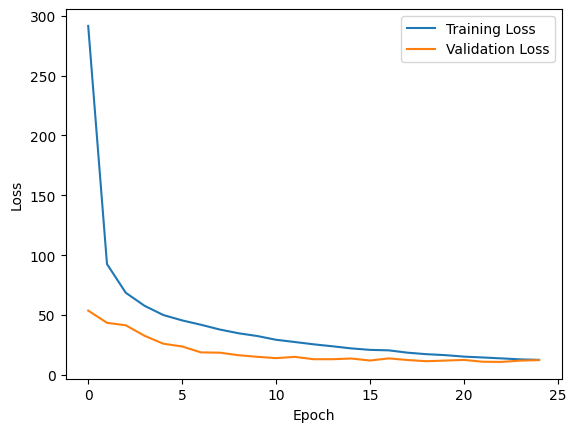

In [152]:
plt.figure()
plt.plot(total_train_loss, label="Training Loss")
plt.plot(total_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

> Validation loss is lower than training loss possibly because of our dropout layers.